In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay

In [2]:
# Load data
data = pd.read_csv("data_2002_2024.csv")
data

,team,season,week,total_yards,def_yards_allowed,turnovers,possession_time,pass_yards,rush_yards,third_down_pct,redzone_pct,point_diff,ypp,result,is_champion
0,49ers,2002,17,329,263,2,2137,136,193,0.428571,0.000000,-11,5.222222,0,0
1,49ers,2002,16,358,184,2,2059,252,106,0.550000,0.000000,3,4.904110,1,0
2,49ers,2002,15,263,302,1,1437,156,107,0.461538,0.000000,-6,4.614035,0,0
3,49ers,2002,14,401,257,1,2159,276,125,0.500000,0.000000,4,4.717647,1,0
4,49ers,2002,13,299,507,2,1945,157,142,0.562500,0.000000,7,4.397059,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7355,Vikings,2024,13,273,406,1,1451,205,68,0.125000,0.500000,1,5.352941,1,0
7356,Vikings,2024,12,452,398,1,2006,328,124,0.461538,0.428571,3,6.953846,1,0
7357,Vikings,2024,11,318,294,1,1951,236,82,0.357143,1.000000,10,4.746269,1,0
7358,Vikings,2024,10,402,143,3,2539,233,169,0.357143,0.000000,5,4.902439,1,0


In [3]:
# Prepare features and labels
X = data.drop(columns=["team", "season", "week", "result","is_champion", "point_diff"])
y = data["result"]

In [4]:
# Set up model and cross-validation

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

# Lists to store fold results
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
train_acc_list = []
test_acc_list = []
total_cm = np.zeros((2, 2), dtype=int)

In [5]:
# 10-Fold Cross-Validation Loop
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    recall_list.append(recall_score(y_test, y_pred, average='weighted'))
    f1_list.append(f1_score(y_test, y_pred, average='weighted'))
    roc_auc_list.append(roc_auc_score(y_test, y_proba))
    train_acc_list.append(model.score(X_train, y_train))
    test_acc_list.append(model.score(X_test, y_test))

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    total_cm += cm

In [6]:
# Print Cross-Validation Results

print("10-Fold Cross-Validation Results:\n")
print(f"Accuracy: {np.mean(accuracy_list):.4f} ± {np.std(accuracy_list):.4f}")
print(f"Precision: {np.mean(precision_list):.4f} ± {np.std(precision_list):.4f}")
print(f"Recall: {np.mean(recall_list):.4f} ± {np.std(recall_list):.4f}")
print(f"F1 Score: {np.mean(f1_list):.4f} ± {np.std(f1_list):.4f}")
print(f"ROC AUC: {np.mean(roc_auc_list):.4f} ± {np.std(roc_auc_list):.4f}\n")
print(f"Train Acc: {np.mean(train_acc_list):.4f} ± {np.std(train_acc_list):.4f}")
print(f"Test Acc: {np.mean(test_acc_list):.4f} ± {np.std(test_acc_list):.4f}\n")

train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
print(f"Train Acc (Last Fold): {train_acc:.4f}, Test Acc (Last Fold): {test_acc:.4f}")

10-Fold Cross-Validation Results:

Accuracy: 0.7742 ± 0.0146
Precision: 0.7746 ± 0.0149
Recall: 0.7742 ± 0.0146
F1 Score: 0.7741 ± 0.0146
ROC AUC: 0.8541 ± 0.0141

Train Acc: 0.9701 ± 0.0032
Test Acc: 0.7742 ± 0.0146

Train Acc (Last Fold): 0.9725, Test Acc (Last Fold): 0.7405


In [7]:
# Last Fold Results and Confusion Matrices
print("\nConfusion Matrix (Last Fold):")
print(confusion_matrix(y_test, y_pred))

print("\nConfusion Matrix (10-Fold CV):")
print(total_cm)

print("\nClassification Report (Last Fold):")
print(classification_report(y_test, y_pred, target_names=["Loss", "Win"], zero_division=0))


Confusion Matrix (Last Fold):
[[273  95]
 [ 96 272]]

Confusion Matrix (10-Fold CV):
[[2878  811]
 [ 851 2820]]

Classification Report (Last Fold):
              precision    recall  f1-score   support

        Loss       0.74      0.74      0.74       368
         Win       0.74      0.74      0.74       368

    accuracy                           0.74       736
   macro avg       0.74      0.74      0.74       736
weighted avg       0.74      0.74      0.74       736



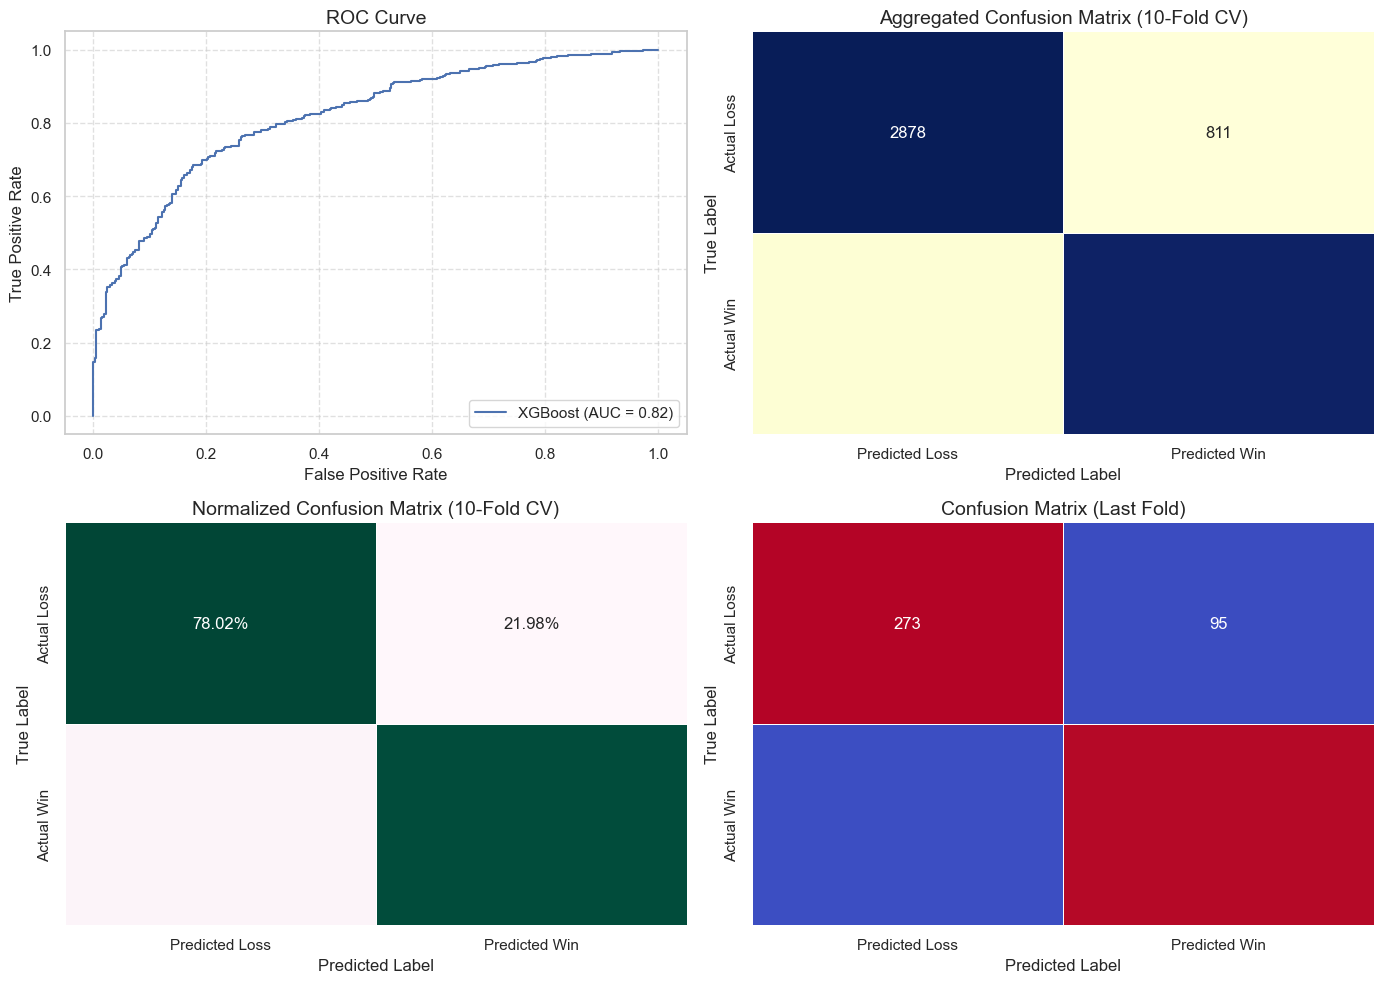

In [8]:
# Plot ROC Curve and Confusion Matrices

cm_normalized = total_cm.astype('float') / total_cm.sum(axis=1, keepdims=True)

sns.set_theme(style="whitegrid")
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 100

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: ROC Curve (Last Fold)
RocCurveDisplay.from_predictions(y_test, y_proba, name="XGBoost", ax=axes[0, 0])
axes[0, 0].set_title("ROC Curve")
axes[0, 0].set_xlabel("False Positive Rate")
axes[0, 0].set_ylabel("True Positive Rate")
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

# Plot 2: Aggregated Confusion Matrix (10-Fold CV)
sns.heatmap(total_cm, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5,
            xticklabels=["Predicted Loss", "Predicted Win"],
            yticklabels=["Actual Loss", "Actual Win"],
            cbar=False, ax=axes[0, 1])
axes[0, 1].set_title("Aggregated Confusion Matrix (10-Fold CV)")
axes[0, 1].set_xlabel("Predicted Label")
axes[0, 1].set_ylabel("True Label")

# Plot 3: Normalized Confusion Matrix (10-Fold CV)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='PuBuGn', linewidths=.5,
            xticklabels=["Predicted Loss", "Predicted Win"],
            yticklabels=["Actual Loss", "Actual Win"],
            cbar=False, ax=axes[1, 0])
axes[1, 0].set_title("Normalized Confusion Matrix (10-Fold CV)")
axes[1, 0].set_xlabel("Predicted Label")
axes[1, 0].set_ylabel("True Label")

# Plot 4: Confusion Matrix (Last Fold)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', linewidths=.5,
            xticklabels=["Predicted Loss", "Predicted Win"],
            yticklabels=["Actual Loss", "Actual Win"],
            cbar=False, ax=axes[1, 1])
axes[1, 1].set_title("Confusion Matrix (Last Fold)")
axes[1, 1].set_xlabel("Predicted Label")
axes[1, 1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

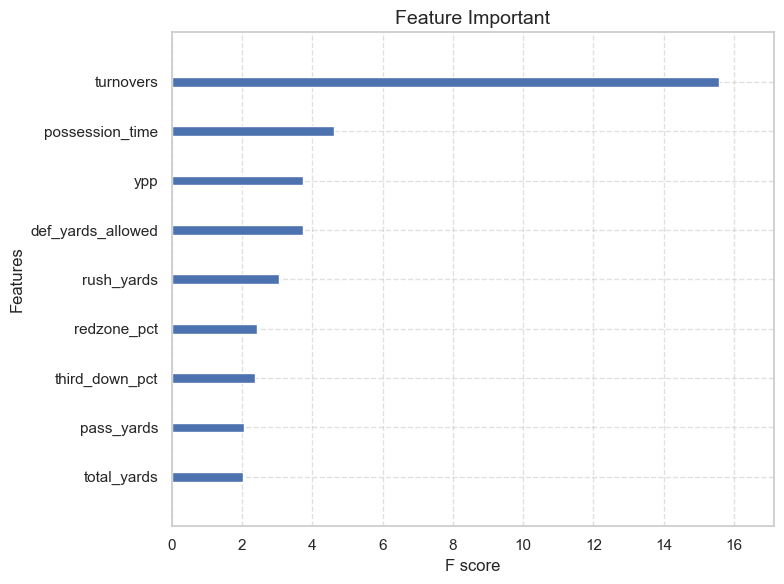

In [9]:
# Plot Feature Importance
xgb.plot_importance(model, importance_type='gain', show_values=False)
plt.title("Feature Important", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()